In [19]:
pwd

'/home/jovyan/private/PycharmProjects/FlexGen-EHR-master/FlexGen-master'

In [20]:
from models.cvae import VariationalAutoencoder, vae_loss_fn
from models.ddpm import DDPM, ContextUnet
from models.flexgen import flexgen
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pandas as pd
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

class MIMICDATASET(Dataset):
    def __init__(self, x_t,x_s, y, train=None, transform=None):
        # Transform
        self.transform = transform
        self.train = train
        self.xt = x_t
        self.xs = x_s
        self.y = y

    def return_data(self):
        return self.xt, self.xs, self.y

    def __len__(self):
        return len(self.xt)

    def __getitem__(self, idx):
        sample = self.xt[idx]
        stat = self.xs[idx]
        sample_y = self.y[idx]
        return sample, stat, int(sample_y)

In [21]:
class CVAE(torch.nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, hidden_dim):
        super(CVAE, self).__init__()
        # 인코더
        self.fc1 = torch.nn.Linear(input_dim + condition_dim, hidden_dim)
        self.fc21 = torch.nn.Linear(hidden_dim, latent_dim)  # 잠재 변수의 평균
        self.fc22 = torch.nn.Linear(hidden_dim, latent_dim)  # 잠재 변수의 로그 분산
        # 디코더
        self.fc3 = torch.nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, input_dim)

    def encode(self, x, c):
        # 입력 이미지와 조건 레이블을 결합
        x_cond = torch.cat([x, c], dim=1)
        h1 = torch.nn.functional.relu(self.fc1(x_cond))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # 잠재 변수와 조건 레이블을 결합
        z_cond = torch.cat([z, c], dim=1)
        h3 = torch.nn.functional.relu(self.fc3(z_cond))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

In [22]:
batch_size =  512
device = torch.device("cuda")
tasks = [
    'mortality_48h',
    'ARF_4h', 
    'ARF_12h',
    'Shock_4h',
    'Shock_12h',
]

task = tasks[0]

# dataset_name = "eICU"
dataset_name = "MIMIC"

s = np.load(f'FIDDLE_{dataset_name}/features/{task}/s.npz')
X = np.load(f'FIDDLE_{dataset_name}/features/{task}/X.npz')
s_feature_names = json.load(open(f'FIDDLE_{dataset_name}/features/{task}/s.feature_names.json', 'r'))
X_feature_names = json.load(open(f'FIDDLE_{dataset_name}/features/{task}/X.feature_names.json', 'r'))
df_pop = pd.read_csv(f'FIDDLE_{dataset_name}/population/{task}.csv')
x_s = torch.sparse_coo_tensor(torch.tensor(s['coords']), torch.tensor(s['data'])).to_dense().to(torch.float32)
x_t = torch.sparse_coo_tensor(torch.tensor(X['coords']), torch.tensor(X['data'])).to_dense().to(torch.float32)

print(x_s.shape)
print(x_t.shape)

x_t = x_t.sum(dim=1).to(torch.float32)

print(x_t.shape)


y = torch.tensor(df_pop["mortality_LABEL"].values).to(torch.float32)
print(y.shape)
dataset_train_object = MIMICDATASET(x_t, x_s, y,  train=True, transform=False)
train_loader = DataLoader(dataset_train_object, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=False)

torch.Size([8577, 96])
torch.Size([8577, 48, 7307])
torch.Size([8577, 7307])
torch.Size([8577])


loss: 0.9725: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


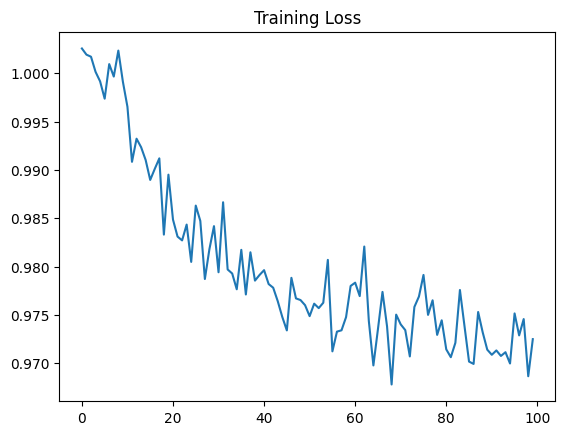


torch.Size([1000, 1000]) torch.Size([1000, 2])


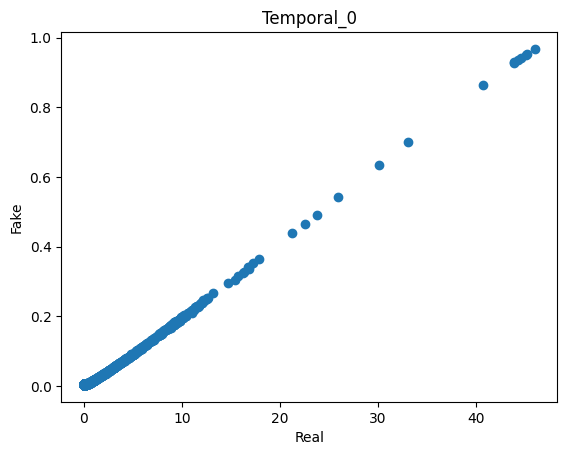

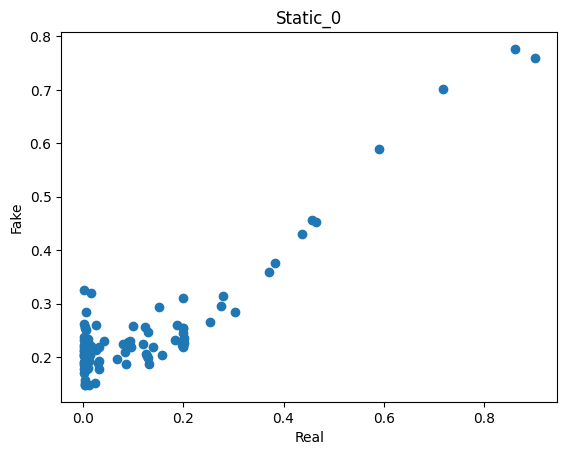


torch.Size([1000, 1000]) torch.Size([1000, 2])


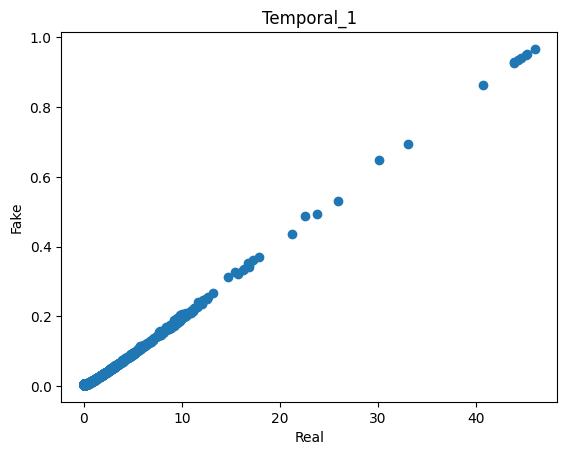

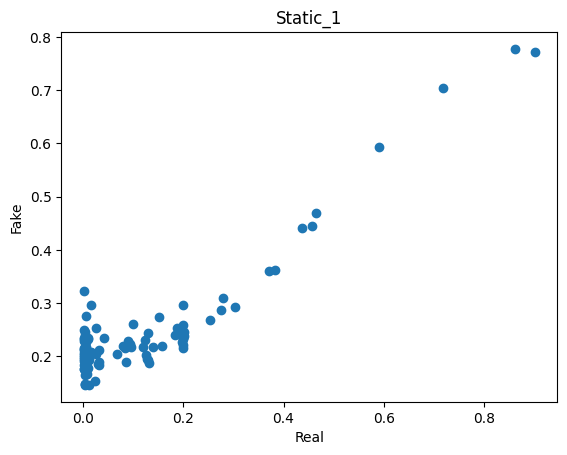

In [23]:
# 필요한 값만 언팩
tmp_samples, sta_samples, _ = next(iter(train_loader))
feature_dim_s = sta_samples.shape[1]
feature_dim_t = tmp_samples.shape[1]

# svae = VariationalAutoencoder(feature_dim_s).to(device)
# tvae = VariationalAutoencoder(feature_dim_t).to(device)
svae = CVAE(feature_dim_s, 2, 20, 50).to(device)
tvae = CVAE(feature_dim_t, 2, 1000, 3000).to(device)
tvae_dict = torch.load(f'saved_models_{dataset_name}/my_vae_tmp.pth', weights_only=True)
svae_dict = torch.load(f'saved_models_{dataset_name}/my_vae_stat.pth', weights_only=True)
tvae.load_state_dict(tvae_dict)
svae.load_state_dict(svae_dict)
svae.eval()
tvae.eval()
n_epoch = 100
n_T = 10
device = "cuda"
n_classes = 2
n_feat = 1020
betas = (1e-4, 0.02)
save_model = True
w = 0.1
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=2), betas=betas, n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)
trainer = flexgen(tvae, svae, ddpm, train_loader, dataset_name, epochs=n_epoch)
trainer.train_epoch()

s0_syn, t0_syn = trainer.generate(1000, 0)
s1_syn, t1_syn = trainer.generate(1000, 1)

s_syn = np.concatenate([s0_syn, s1_syn], axis=0)
t_syn = np.concatenate([t0_syn, t1_syn], axis=0)

np.save(f'Synthetic_{dataset_name}/flexgen_static.npy', s_syn)
np.save(f'Synthetic_{dataset_name}/flexgen_temporal.npy', t_syn)

In [24]:
s_syn = np.load(f'Synthetic_{dataset_name}/flexgen_static.npy')
t_syn = np.load(f'Synthetic_{dataset_name}/flexgen_temporal.npy')
print(s_syn.shape, t_syn.shape)

(2000, 96) (2000, 7307)


In [25]:
syn = np.concatenate([s_syn, t_syn], axis=1)
ori = np.concatenate([x_s.cpu().numpy(), x_t.cpu().numpy()], axis=1)

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# 
# 
# # t-SNE 모델 생성
# tsne = TSNE(n_components=2, random_state=42)
# 
# # 데이터 변환
# syn_tsne = tsne.fit_transform(s_syn)
# ori_tsne = tsne.fit_transform(x_s.cpu().numpy())
# 
# # 시각화
# plt.figure(figsize=(12, 6))
# 
# plt.subplot(1, 2, 1)
# plt.scatter(syn_tsne[:, 0], syn_tsne[:, 1], s=1)
# plt.title('t-SNE Visualization of syn')
# 
# plt.subplot(1, 2, 2)
# plt.scatter(ori_tsne[:, 0], ori_tsne[:, 1], s=1)
# plt.title('t-SNE Visualization of ori')
# 
# plt.show()

In [27]:
# # t-SNE 모델 생성
# tsne = TSNE(n_components=2, random_state=42)
# 
# # 데이터 변환
# syn_tsne = tsne.fit_transform(t_syn)
# ori_tsne = tsne.fit_transform(x_t.cpu().numpy())
# 
# # 시각화
# plt.figure(figsize=(12, 6))
# 
# plt.subplot(1, 2, 1)
# plt.scatter(syn_tsne[:, 0], syn_tsne[:, 1], s=1)
# plt.title('t-SNE Visualization of syn')
# 
# plt.subplot(1, 2, 2)
# plt.scatter(ori_tsne[:, 0], ori_tsne[:, 1], s=1)
# plt.title('t-SNE Visualization of ori')
# 
# plt.show()